In [1]:
from dask.distributed import Client, wait
from dask import delayed, persist
import dask.array as da

from functions import cholesky_tsqr, indirect_tsqr, direct_tsqr
import numpy as np

import gc

The condition number of a matrix with respect to the $L^2$-norm is defined as the ratio of its largest to smallest singular value:
$$\kappa(A)=\frac{\sigma_{\text{max}}(A)}{\sigma_{\text{min}}(A)}$$
By prescribing singular values and applying the singular value decomposition (SVD), we can construct an ill-conditioned matrix.

In [2]:
def generate_ill_conditioned(shape : tuple, cond : float) -> np.ndarray:
    ''' 
    Generate an ill-conditioned matrix of given shape and condition number.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the matrix to be generated (m, n).
    cond : float
        Condition number of the matrix.

    Returns:
    --------
    np.ndarray
        An ill-conditioned matrix of shape (m, n) with the specified condition number.
    '''
    n, m = shape
    k = min(m, n)

    s = np.linspace(1, 1/cond, k)

    U, _ = np.linalg.qr(np.random.randn(m,m))
    V, _ = np.linalg.qr(np.random.randn(n,n))

    S = np.zeros((m,n))
    np.fill_diagonal(S, s)
    return U @ S @ V

In [3]:
N_WORKERS = 3
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "4GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

DASK Client with 3 workers (1 threads, 4GB memory)
Dashboard: http://127.0.0.1:8787/status


In [37]:
n, m = 4, 1_000   # Fixed matrix shape
cond = np.logspace(0, 8, 10, base=10.0)    # Condition numbers to test

results = {
    "Cholesky": (cholesky_tsqr, []),
    "Indirect": (indirect_tsqr, []),
    "Direct": (direct_tsqr, []),
}

for c in cond:
    print(f"Condition number: {c:.1e}")
    # Creation of a random ill-conditioned array inside the
    # workers, subdivided evenly in N_WORKERS chunks.
    A = generate_ill_conditioned((n, m), c)
    chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(m - sum(chunks))
    X_da = da.from_array(A, chunks=(chunks, n))
    X_da.persist()

    for name, (algorithm, _) in results.items():
        print(f"  {name}", end=" ")
        Q, _ = algorithm(X_da)
        Qt = delayed(np.transpose)(Q)
        _tmp = delayed(np.linalg.matmul)(Qt, Q)
        _tmp = _tmp.compute()   # _tmp is now small (n x n)
        wait(_tmp)
        
        # Compute the orthogonality error
        orthogonality = np.linalg.norm(_tmp - np.eye(n))
        print(f"({orthogonality:.1e})")
        results[name][1].append(orthogonality)
        
        # Clean memory from previous computations
        client.cancel(Q)
    
    print()
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)


Condition number: 1.0e+00
  Cholesky (2.5e-16)
  Indirect (6.7e-16)
  Direct (4.1e-16)

Condition number: 7.7e+00
  Cholesky (5.9e+00)
  Indirect (2.0e-15)
  Direct (9.2e-16)

Condition number: 6.0e+01
  Cholesky (1.3e+03)
  Indirect (3.5e-15)
  Direct (6.8e-16)

Condition number: 4.6e+02
  Cholesky (9.9e+04)
  Indirect (1.7e-13)
  Direct (7.7e-16)

Condition number: 3.6e+03
  Cholesky (1.6e+06)
  Indirect (2.7e-13)
  Direct (5.5e-16)

Condition number: 2.8e+04
  Cholesky (3.2e+08)
  Indirect (2.3e-12)
  Direct (7.1e-16)

Condition number: 2.2e+05
  Cholesky (2.8e+10)
  Indirect (1.7e-11)
  Direct (5.5e-16)

Condition number: 1.7e+06
  Cholesky (6.3e+11)
  Indirect (1.7e-10)
  Direct (8.6e-16)

Condition number: 1.3e+07
  Cholesky (4.9e+13)
  Indirect (9.0e-10)
  Direct (3.4e-16)

Condition number: 1.0e+08
  Cholesky (7.3e+15)
  Indirect (2.5e-09)
  Direct (5.1e-16)



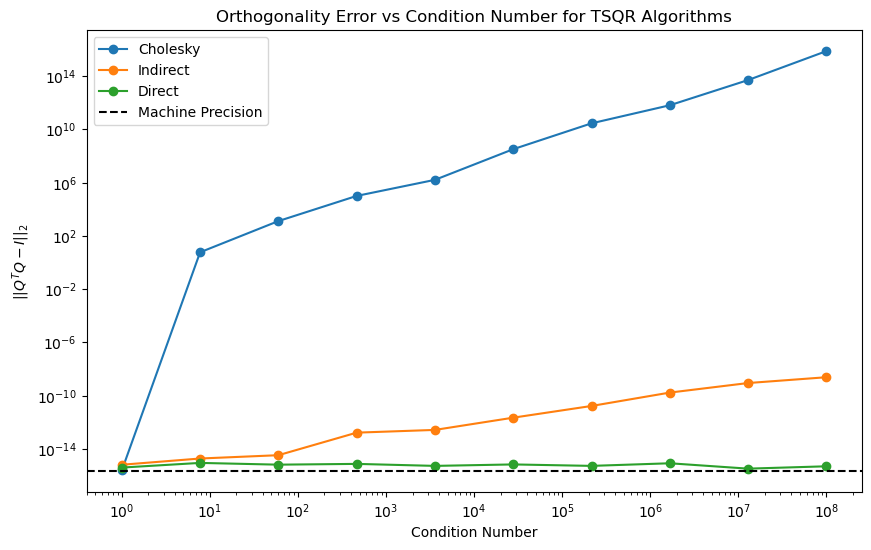

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, (_, orthogonalities) in results.items():
    plt.plot(cond, orthogonalities, marker='o', label=name)
plt.axhline(y=np.finfo(float).eps, color='k', linestyle='--', label='Machine Precision')
plt.xlabel('Condition Number')
plt.ylabel('$||Q^T Q - I||_2$')
plt.title('Orthogonality Error vs Condition Number for TSQR Algorithms')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()